## Figures 12 and 13: 
## Maps of surface presence and volumes by oil types

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

This notebook relies on functions in `monte_carlo_utils.py` and requires the inclusion of the directory with this script, namely `../../../scripts`, in PYTHONPATH, e.g.:
```
export PYTHONPATH=$PYTHONPATH:/path/to/analysis-rachael/scripts
```
or uncommenting the following lines to import the scripts directory using sys: 
```
import sys
sys.path.insert(0, '../../../scripts')
```

In [68]:
# import cmocean.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import os
import matplotlib.ticker as ticker
import matplotlib

# set colormap so it's white (water) and papayawhip (land)
my_cmap = matplotlib.cm.get_cmap('Greens').copy()
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

%matplotlib inline

# graphics style
#plt.style.use('seaborn-poster')
#plt.style.use(r"./meopar2022_matplotlibrc.template")

In [7]:
# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']

# define directory paths
if os.sys.platform=="darwin": # For Shuga
    graphics_directory = Path(
         '/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/JGR_graphics'
    )
    # Aggregated files path
    agg_dir = Path('/Volumes/Elements/Data/aggregated_spills/')
    # monte carlo spills file
    spill_dir = Path('/Volumes/Elements/Data/spill_files_091921/')
    # graphics style
    plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")
else:
    # Aggregated files path
    agg_dir = Path('/data/sallen/MIDOSS/aggregated_spills_files/')
    # monte carlo spills file
    spill_dir = Path('/ocean/rmueller/MIDOSS/spill_files_091921/')
    # MEOPAR ASM graphics directory
    graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics')
    

In [8]:
# define names used for Lagrangian files
oil_template_names = [
    'Lagrangian_akns.dat','Lagrangian_bunker.dat',
     'Lagrangian_diesel.dat','Lagrangian_gas.dat',
     'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
     'Lagrangian_other.dat'
]
# define desired, end-product names for oil-types
oil_types = [
    'ANS','Bunker-C',
    'Diesel','Diesel',
    'Diesel','Dilbit', 
    'Bunker-C'
]
# for mapping of one dictionary key to a different dictionary key
key_map = {
    'akns':'ANS',
    'bunker':'Bunker-C',
    'diesel':'Diesel',
    'dilbit':'Dilbit' 
}

# load spills file
spill_init=pd.read_csv(spill_dir/'SalishSea_oil_spills_4.csv')
# replace Lagrangian template file names with oil type tags
spill_init['oil_type'] = spill_init['Lagrangian_template'].replace(
    oil_template_names, 
    oil_types
)

## Monte carlo spills file information

In [9]:
# volume of spills by oil type (converted to megaliters)
volume = dict(spill_init.groupby('oil_type').spill_volume.sum()/1e6)
volume_max = dict(spill_init.groupby('oil_type').spill_volume.max()/1e6)
# number of spills by oil type
number_spills=dict(spill_init[['oil_type','spill_date_hour']].groupby('oil_type').count().rename(columns={'spill_date_hour':'N spills'}))
# geometric mean of spills
spill_init['spill_volume_ln'] = np.log(spill_init['spill_volume'])
geomean = dict(np.exp(spill_init.groupby('oil_type').spill_volume_ln.sum()/number_spills['N spills'])/1e6)

## SalishSeaCast grid specifications

In [11]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
# e1t = dx
# e2t = dy
# alength = 1/(length scale), where length is the largest of dx,dy
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

# mesh = xr.open_dataset('/home/rmueller/data/SalishSeaCast/grid/mesh_mask201702.nc')
# tmask = 1- mesh.tmask[0, 0]
# divarea = 1/(mesh.e1t[0, 1:-1, 1:-1] * mesh.e2t[0, 1:-1, 1:-1]) # e1t = dx, e2t = dy
# alength = 1/np.maximum(mesh.e1t[0, 1:-1:, 1:-1], mesh.e2t[0, 1:-1, 1:-1])
# mesh.close()

In [12]:
beach={}
water={}
sfc={}
sfc_presence_diff={}
sfc_presence={}
ma_surface_diff={}
ma_surface={}

In [13]:
# add all oils surface presence
eps = 1e-7
cubicmeter_to_ML = 1e-3
oil = xr.open_dataset(agg_dir/f'fiftieth_55_oils.nc')
ma_surface_oil = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), oil.oilpresence == 0)
ma_oil_pres = np.ma.masked_array(oil.oilpresence, oil.oilpresence == 0)
ma_surface_all=ma_surface_oil
sfc_presence_all = ma_oil_pres

In [14]:
## Load oil types
oil_types = ['akns','bunker','diesel','dilbit']
for oil_type in oil_types:
    print(f'***{oil_type}***')
    
    oil = xr.open_dataset(agg_dir/f'fiftieth_55_{oil_type}.nc')
    
    # geometric mean beached oil
    ma_beach_oil = np.ma.masked_array(
        oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0
    )
    beach2d = np.exp(ma_beach_oil)
    
    # geometric mean Deep Oil (depth integrated: $m^3$)
    ma_deep_oil = np.ma.masked_array(
        oil.deep_oil[0]/(oil.deeppresence + eps), oil.deeppresence == 0
    )
    water2d = np.exp(ma_deep_oil)
       
    # Surface Oil Geometric mean thickness ($m^3$)
    ma_surface_oil = np.ma.masked_array(
        oil.surface_oil[0]/(oil.oilpresence + eps), oil.oilpresence == 0
    ) 
    sfc2d = np.exp(ma_surface_oil)
        
    # Surface Oil Presence
    ma_oil_pres = np.ma.masked_array(
        oil.oilpresence, oil.oilpresence == 0
    )
    # Store surface thickness by oil type
    ma_surface_diff[oil_type]=ma_surface_all-ma_surface_oil
    ma_surface[oil_type]=ma_surface_oil    
    # Store surface poresence by oil type
    sfc_presence_diff[oil_type]=sfc_presence_all-ma_oil_pres
    sfc_presence[oil_type]=ma_oil_pres
    
    # create dictionaries used for plotting results
    water[oil_type] = water2d.sum()*cubicmeter_to_ML
    sfc[oil_type] = sfc2d.sum()*cubicmeter_to_ML
    beach[oil_type] = beach2d.sum()*cubicmeter_to_ML

***akns***
***bunker***
***diesel***
***dilbit***


In [15]:
# volume = pd.DataFrame(
#     spill_init.groupby('oil_type').spill_volume.sum(), 
#     columns=['ANS', 'Bunker-C', 'Dilbit', 'Diesel']
# )
# volume_max = pd.DataFrame(
#     spill_init.groupby('oil_type').spill_volume.max(), 
#     columns=['ANS', 'Bunker-C', 'Dilbit', 'Diesel']
# )

In [16]:
# create an empty dictionary named "total" that has the same keys as "water"
total = {**water}
for key, value in water.items():
    total[key] = [value , sfc[key], beach[key]]

#### The difference in geometric mean volume between Bunker-C and ANS is larger than I expected it would be.  Exploring....

In [22]:
# # create an empty dictionary named "total" that has the same keys as "water"
# total_volume = {**water}
# volume_fraction = {**water}
# mean_volume ={**water}
# print('oil type \t total volume \t mean volume \t geo. mean \t g.mean/"mean volume"')
# for key, value in water.items():
#     total_volume[key] = water[key]+sfc[key]+beach[key]
#     # key_map is used to map from one dictionary key to the other
#     mean_volume[key]=volume[key_map[key]]/number_spills['N spills'][key_map[key]]
#     volume_fraction[key]=mean_volume[key]/volume[key_map[key]]
#     print(f'{key} \t\t {volume[key_map[key]]:04.3e} \t {mean_volume[key]:04.3e} \t {total_volume[key]:4.2f}\t\t{volume_fraction[key]:4.2f}')

oil type 	 total volume 	 mean volume 	 geo. mean 	 g.mean/"mean volume"
akns 		 5.665e+02 	 8.583e+00 	 356.40		0.02
bunker 		 1.182e+03 	 3.397e-01 	 66.87		0.00
diesel 		 1.063e+03 	 1.647e-01 	 19.14		0.00
dilbit 		 1.250e+00 	 1.250e+00 	 4.30		1.00


In [26]:
# # geometric mean beached oil
# ma_beach_oil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0)
# beach['ans'] = np.exp(ma_beach_oil) * alength * 1000

In [30]:
thefile = agg_dir/'fiftieth_55_oils.nc'
oil = xr.open_dataset(thefile)
whichspills = "All Oil Spills"
smalloils = 113 + 54

In [31]:
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

In [32]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = colors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [33]:
import cmocean.cm as cm
minColor = 0.1
maxColor = 0.85
thermal_r_t = truncate_colormap(cm.thermal_r, minColor, maxColor)

## Beached oil

In [34]:
# Good if good to half a day or 15% of beaching time
absol = 0.5
perol = 0.15
eps = 1e-7
mcsize = 49

bt_absol = absol
bt_perol = perol
# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

bv_perol = perol



In [35]:
ma_beach_oil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), oil.beachpresence == 0)

den = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
beachoil_ste = np.std(oil.beaching_oil/(oil.beachpresence + eps), axis=0, ddof=1) / np.sqrt(den)
beachedoil = np.ma.masked_array(oil.beaching_oil[0]/(oil.beachpresence + eps), (oil.beachpresence <= 1) | (
    (beachoil_ste > absol) )) 

ma_beachoil_ste = np.ma.masked_array(beachoil_ste, oil.beachpresence <= 0)

In [36]:
# Surface oil presence
ma_oil_pres = np.ma.masked_array(oil.oilpresence, oil.oilpresence == 0)

In [37]:
ma_beaching_time = np.ma.masked_array(oil.beaching_time[0]/(oil.beachpresence + eps), oil.beachpresence == 0)

den = np.minimum(np.array(oil.beachpresence) + eps, mcsize)
beached_ste = np.std(oil.beaching_time, axis=0, ddof=1) / np.sqrt(den)
beached = np.ma.masked_array(oil.beaching_time[0]/(oil.beachpresence + eps), (oil.beachpresence <= 1) | (
    (beached_ste/(oil.beachpresence+eps) > absol) | (beached_ste > perol*oil.beaching_time[0]))) 

ma_beached_ste = np.ma.masked_array(beached_ste/(oil.beachpresence + eps), oil.beachpresence <= 1)

ma_beaching_pres = np.ma.masked_array(oil.beachpresence, oil.beachpresence == 0)

In [38]:
# Good if good to half a day or 15% of arrival time
absol = 0.5
perol = 0.15

at_absol = absol
at_perol = perol

ma_arrival_time = np.ma.masked_array(oil.oiling_time[0]/(oil.oilpresence + eps), oil.oilpresence == 0)

den = np.minimum(np.array(oil.oilpresence) + eps, mcsize)
arrival_ste = np.std(oil.oiling_time, axis=0, ddof=1) / np.sqrt(den)
arrived = np.ma.masked_array(oil.oiling_time[0]/(oil.oilpresence + eps), (oil.oilpresence <= 1) | (
    (arrival_ste/(oil.oilpresence+eps) > absol) | (arrival_ste > perol*oil.oiling_time[0]))) 

ma_arrived_ste = np.ma.masked_array(arrival_ste/(oil.oilpresence + eps), oil.oilpresence <= 1)

In [39]:
# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

sv_perol = perol

# Surface Oil Volume
ma_surface_oil = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), oil.oilpresence == 0)

den = np.minimum(np.array(oil.oilpresence) + eps, mcsize)
surfoil_ste = np.std(oil.surface_oil/(oil.oilpresence + eps), axis=0, ddof=1) / np.sqrt(den)
surfoiled = np.ma.masked_array(oil.surface_oil[0]/(oil.oilpresence + eps), (oil.oilpresence <= 1) | (
    (surfoil_ste > absol) )) 

ma_surfoil_ste = np.ma.masked_array(surfoil_ste, oil.oilpresence <= 0)

In [40]:
#water column oil
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), oil.deeppresence == 0)
den = np.minimum(np.array(oil.deeppresence) + eps, mcsize)
location_ste = np.std(oil.deep_location, axis=0, ddof=1) / np.sqrt(den)
location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1) | (
    (location_ste/(oil.deeppresence+eps) > absol) | (location_ste > perol*oil.deep_location[0]))) 

ma_location_ste = np.ma.masked_array(location_ste/(oil.deeppresence+eps), location_ste == 0)

# Good if good to 5 m or 25% of depth
absol = 5
perol = 0.25

wd_absol = absol
wd_perol = perol

In [41]:
# water column volume
ma_deep_oil = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), oil.deeppresence == 0)

den = np.minimum(np.array(oil.deeppresence) + eps, mcsize)
deepoil_ste = np.std(oil.deep_oil/(oil.deeppresence + eps), axis=0, ddof=1) / np.sqrt(den)
deepoiled = np.ma.masked_array(oil.deep_oil[0]/(oil.deeppresence + eps), (oil.deeppresence <= 1) | (
    (deepoil_ste > absol) )) 

ma_deepoil_ste = np.ma.masked_array(deepoil_ste, oil.deeppresence <= 0)

# Good if good to 100% of beaching volume
perol = 1
absol = np.log(perol+1)

dv_perol = perol

# Surface presence by oil

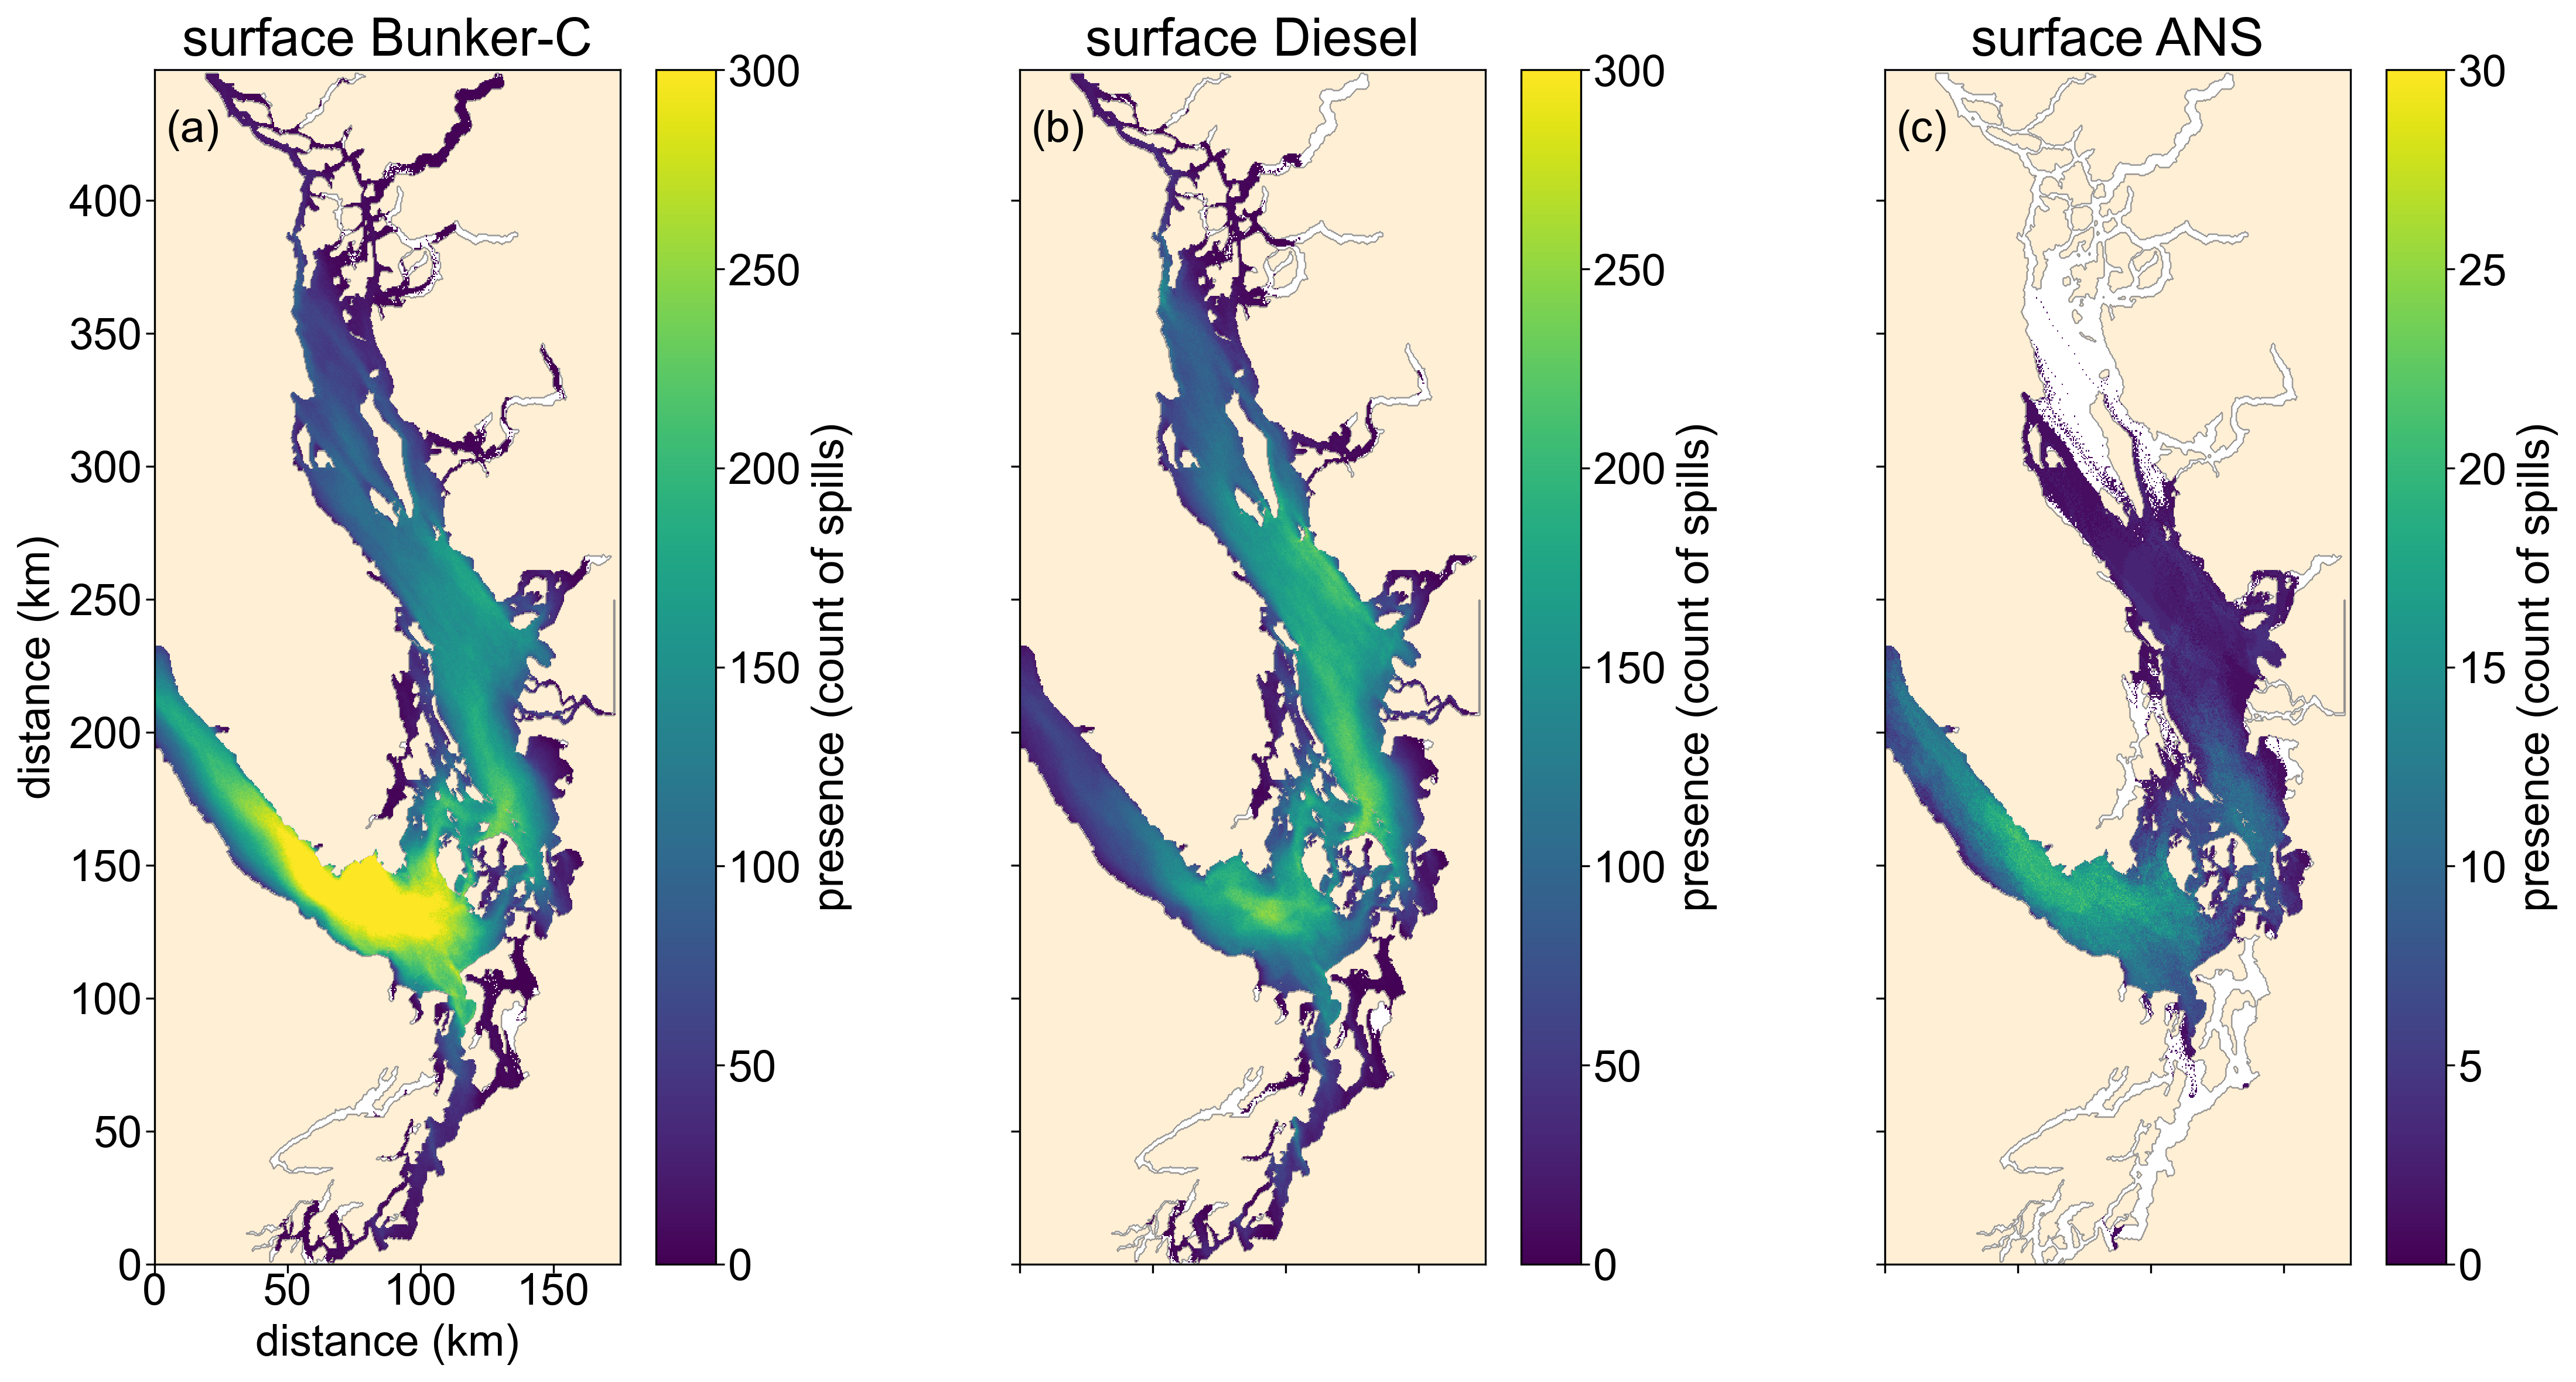

In [73]:
plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")

fig, axs = plt.subplots(1, 3, figsize=(18, 9),
    gridspec_kw={'hspace': 0.0})

vmin, vmax = 0.01, 50

for idx,ax in enumerate(axs):
    ax.pcolormesh(tmask[1:, 1:], cmap=my_cmap, vmin=.1, vmax=.8)
    #ax.pcolormesh(tmask[1:, 1:], cmap=my_cmap, vmin=-0.2, vmax=1.6)
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    # add x- and y-labels using
    # dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
    
    
C = axs[0].pcolormesh(sfc_presence['bunker'], vmin=0,vmax=300, zorder=2)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')
axs[0].set_title('surface Bunker-C');  

C = axs[1].pcolormesh(sfc_presence['diesel'],  vmin=0,vmax=300, zorder=2)
cb = fig.colorbar(C, ax=axs[1]);    
cb.set_label('presence (count of spills)')
axs[1].set_title('surface Diesel');   

C = axs[2].pcolormesh(sfc_presence['akns'],  vmin=0,vmax=30, zorder=2)
cb = fig.colorbar(C, ax=axs[2]);    
cb.set_label('presence (count of spills)')
axs[2].set_title('surface ANS');   


# add suplot labels
subplot_labels=['(a)','(b)','(c)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig(graphics_directory/'Figure10_presence_byOil.png')

## 3-panel figure of surface presence and depth of dispersion

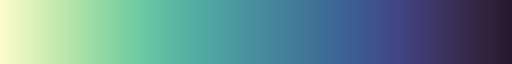

In [50]:
cm.deep.set_under('w')
cm.deep.set_over('g')
cm.deep

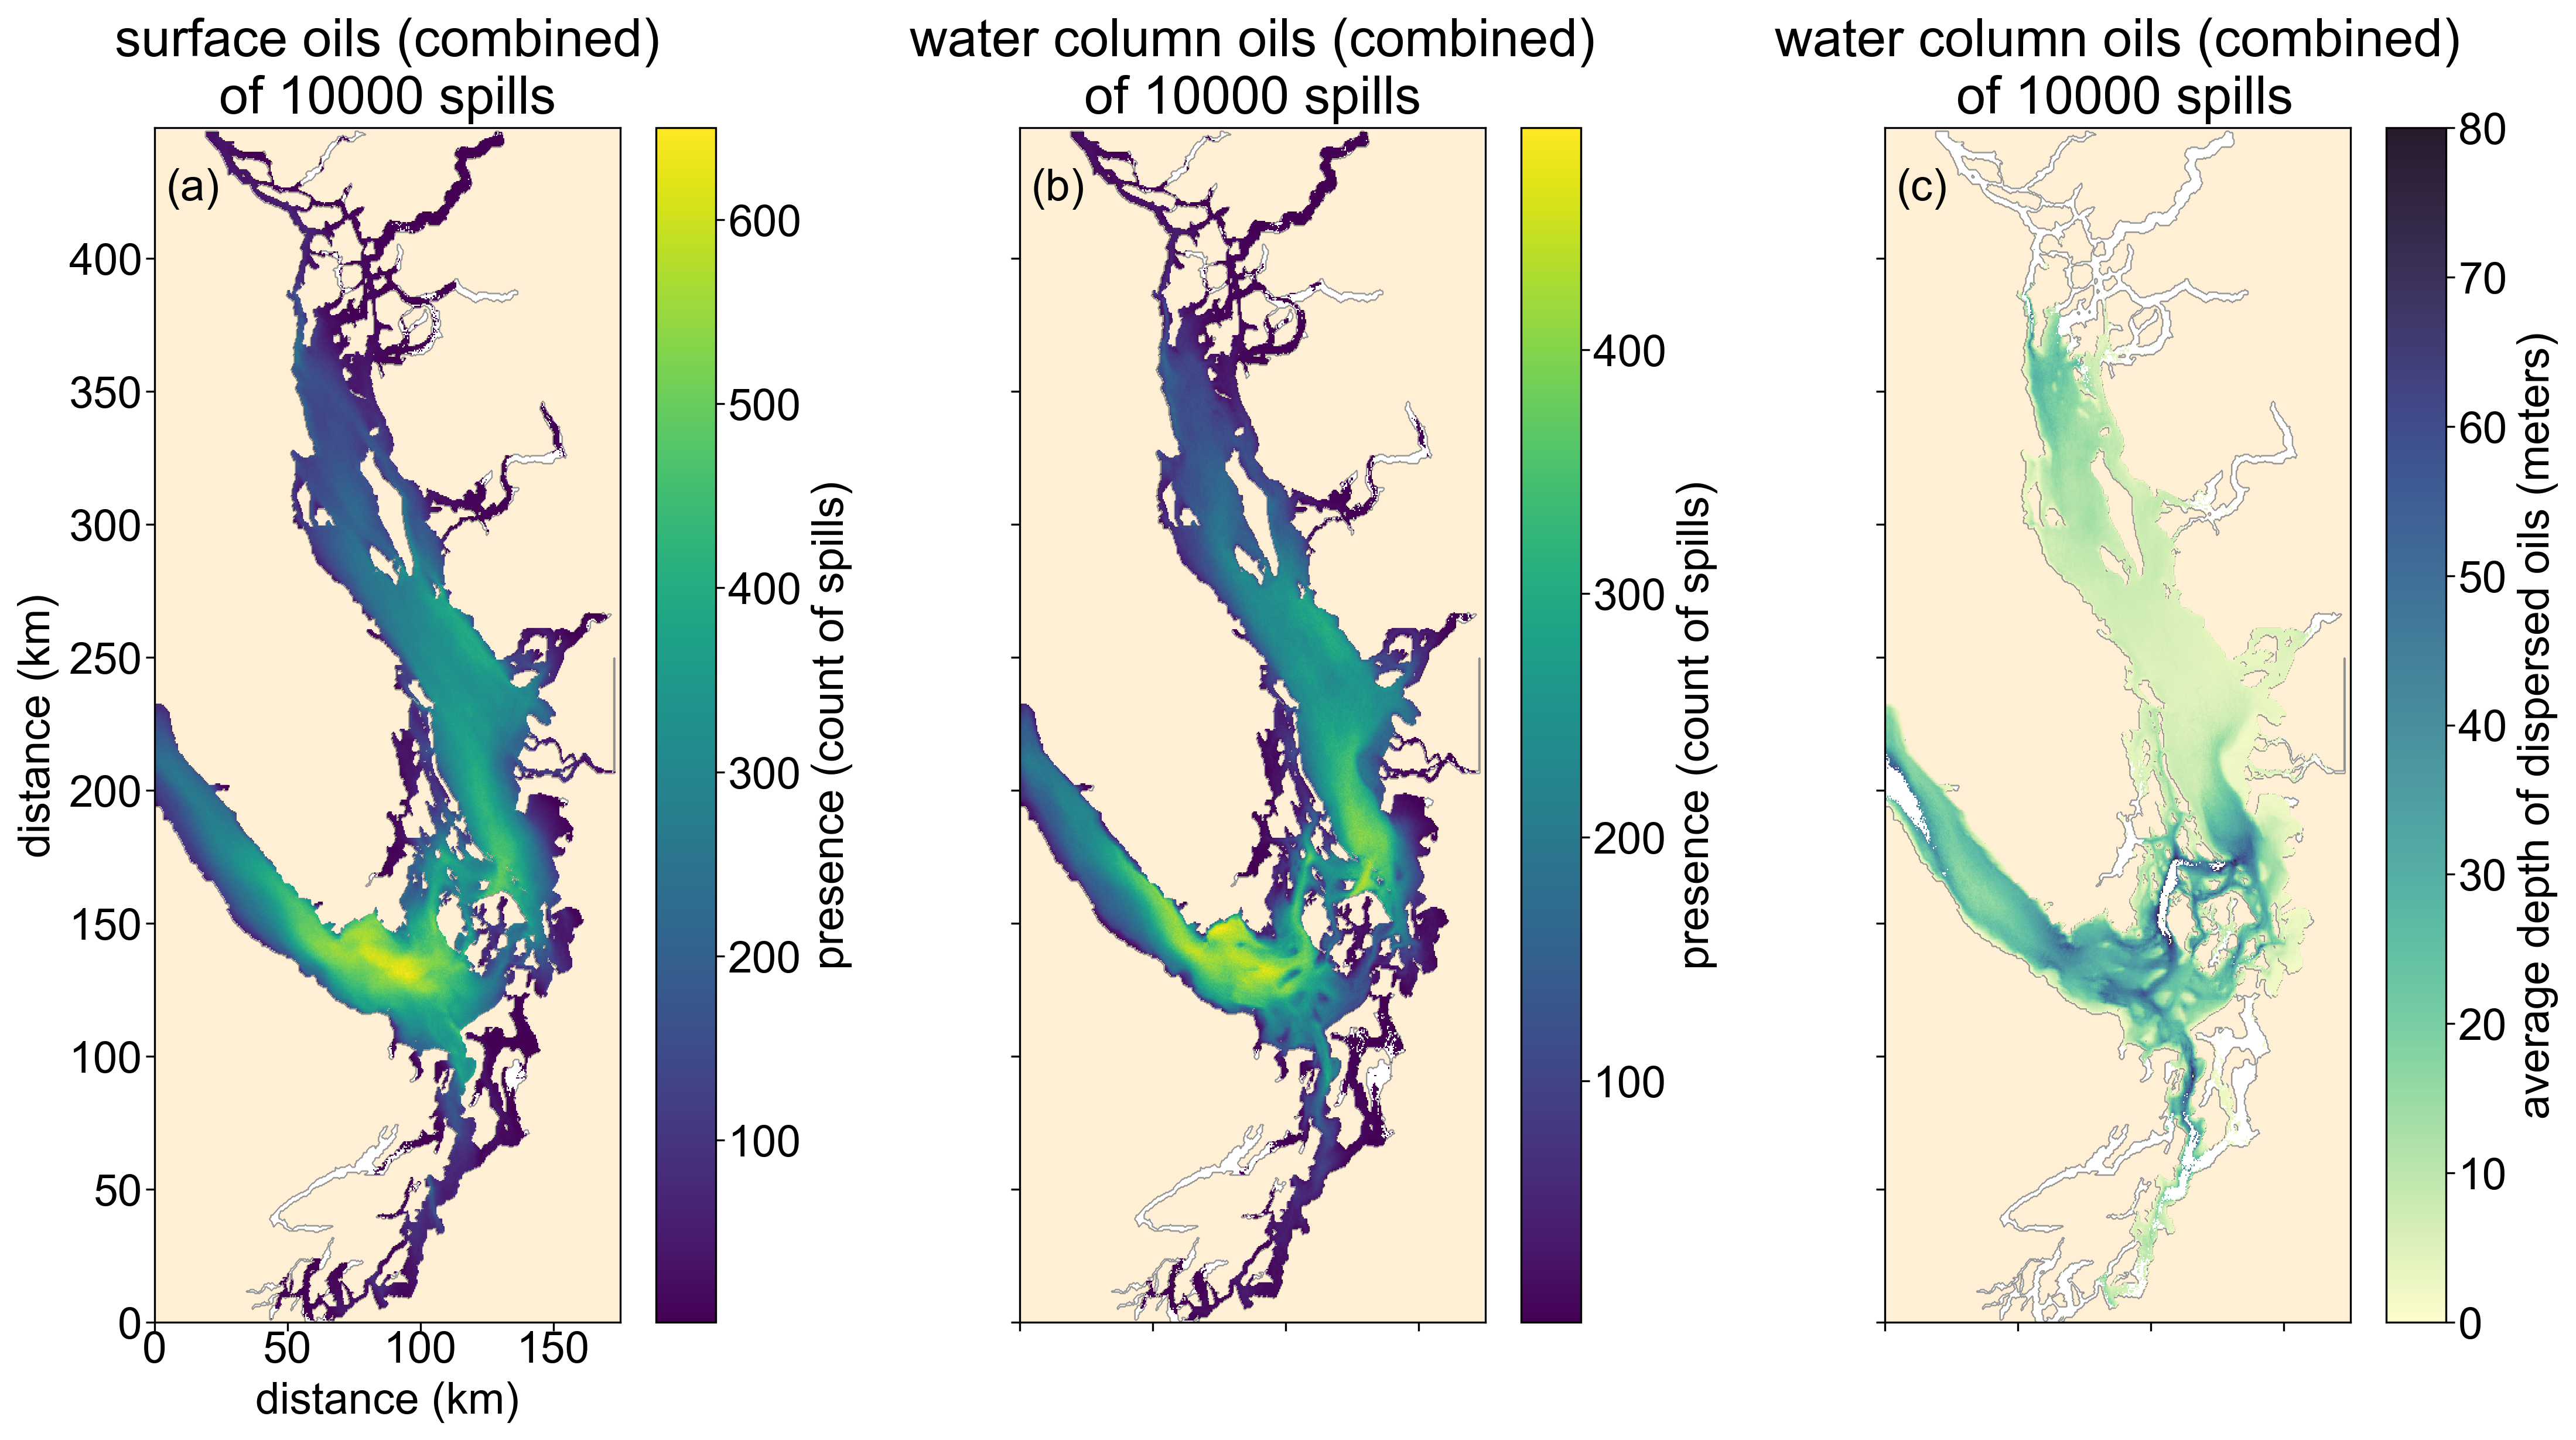

In [72]:
import matplotlib.ticker as ticker
plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")
fig, axs = plt.subplots(
    1, 3, 
    figsize=(18, 9), 
    gridspec_kw={'hspace': 0.0}
)

vmin, vmax = 0.01, 50

for idx,ax in enumerate(axs):
    ax.pcolormesh(tmask[1:, 1:], cmap=my_cmap, vmin=.1, vmax=.8)
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    # add x- and y-labels using
    # dx=440/1000 scale to make "nice" x-axis label intervals 
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
    
C = axs[0].pcolormesh(ma_oil_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')
axs[0].set_title(f'surface oils (combined)\nof {oil.nofiles.values+smalloils} spills');  

C = axs[1].pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[1]);    
cb.set_label('presence (count of spills)')
axs[1].set_title(f'water column oils (combined)\nof {oil.nofiles.values+smalloils} spills');   

C = axs[2].pcolormesh(
     location,
    zorder=2, vmin=0, vmax=80, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('average depth of dispersed oils (meters)')
axs[2].set_title(f'water column oils (combined)\n of {oil.nofiles.values+smalloils} spills');

# add suplot labels
subplot_labels=['(a)','(b)','(c)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig(graphics_directory/'Figure11_surface_presence.png')

In [ ]:


fig, axs = plt.subplots(1, 4, figsize=(24, 9))

vmin, vmax = 0.01, 50

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
  
C = axs[0].pcolormesh(np.exp(ma_surface['akns']) * divarea * 1e6, zorder=2,vmin=0,vmax=50)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Thickness')
axs[0].set_title(f'Surface thickness of ANS');  

C = axs[1].pcolormesh(np.exp(ma_surface['diesel']) * divarea * 1e6, zorder=2,vmin=0,vmax=50)
cb = fig.colorbar(C, ax=axs[1]);    
cb.set_label('Thickness')
axs[1].set_title(f'Thickness of Diesel');   

C = axs[2].pcolormesh(np.exp(ma_surface['bunker']) * divarea * 1e6, zorder=2,vmin=0,vmax=50)
cb = fig.colorbar(C, ax=axs[2]);    
cb.set_label('Thickness')
axs[2].set_title(f'Thickness of Bunker');   

C = axs[3].pcolormesh(np.exp(ma_surface_all) * divarea * 1e6, zorder=2,vmin=0,vmax=50)
cb = fig.colorbar(C, ax=axs[3]);    
cb.set_label('Thickness')
axs[3].set_title(f'Thickness of all');   



# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']
for idx,ax in enumerate(axs):                
    ax.text(10,imax*0.94,subplot_labels[idx])

plt.savefig(graphics_directory/'monte_carlo_thickness_byoil.png')


In [ ]:
sfc_presence['akns'].min()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(18, 9*3+2))

fig.suptitle(f'{whichspills}', fontsize=20)
vmax = 50
vmin = 0.02

for i in range(3):
    for ax in axs[i]:
        ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
        ax.set_ylim(imin, imax)
        ax.set_xlim(jmin, jmax)
        ax.set_aspect(aspect)

        
C = axs[0, 0].pcolormesh(ma_beaching_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[0, 0]);    
cb.set_label('Presence (count of spills)')
axs[0, 0].set_title(f'Beaching Presence (count) of {oil.nofiles.values+smalloils} spills');   

C = axs[0, 1].pcolormesh(beached, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[0, 1]);
cb.set_label('Beaching Time (days)')
axs[0, 1].set_title(f'Screened Mean Beaching Time\n Standard Error less than {bt_absol} days and {bt_perol*100}%');

C = axs[0, 2].pcolormesh(np.exp(beachedoil) * alength * 1000, zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')
cb = fig.colorbar(C, ax=axs[0, 2]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[0, 2].set_title(f'Screened Geometric Mean Beached Oil\n Standard Error less than {bv_perol*100}%');

C = axs[1, 0].pcolormesh(ma_oil_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[1, 0]);    
cb.set_label('Presence (count of spills)')
axs[1, 0].set_title(f'Surface Oil Presence (count) of {oil.nofiles.values+smalloils} spills');  

C = axs[1, 1].pcolormesh(arrived, zorder=2, vmin=0, vmax=7, cmap=thermal_r_t)
cb = fig.colorbar(C, ax=axs[1, 1]);
cb.set_label('Arrival Time (days)')
axs[1, 1].set_title(f'Screened Mean Arrival Time\n Standard Error less than {at_absol} days ad {at_perol*100}%');

C = axs[1, 2].pcolormesh(
     np.exp(surfoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')
cb = fig.colorbar(C, ax=axs[1, 2]);
cb.set_label('Surface Oil ($\mu m$)')
axs[1, 2].set_title(f'Screened Geometric Mean Surface Oil\n Standard Error less than {sv_perol*100}%');


C = axs[2, 0].pcolormesh(ma_deep_pres, zorder=2)
cb = fig.colorbar(C, ax=axs[2, 0]);    
cb.set_label('Presence (count of spills)')
axs[2, 0].set_title(f'Below Surface Oil Presence (count) of {oil.nofiles.values+smalloils} spills');   

C = axs[2, 1].pcolormesh(
     location,
    zorder=2, vmin=0, vmax=75, cmap=cm.deep
)
cb = fig.colorbar(C, ax=axs[2, 1]);
cb.set_label('Depth of Dispersed Oil')
axs[2, 1].set_title(f'Screened Deep Location\n Standard Error less than {wd_absol} m and {wd_perol*100}%');

C = axs[2, 2].pcolormesh(
     np.exp(deepoiled) * divarea * 1e6,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2, 2]);
cb.set_label('Deep Oil (depth integrated: $\mu m$)')
axs[2, 2].set_title(f'Screened Geometric Mean Deep Oil\n Standard Error less than {dv_perol*100}%');

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 9))

vmin, vmax = 0.01, 50

for ax in axs:
    ax.pcolormesh(tmask[1:, 1:], cmap='terrain', vmin=-0.2, vmax=1.6)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)

C = axs[0].pcolormesh(
     np.exp(ma_beach_oil) * alength * 1000, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('Beached Oil ($\ell$/m)')
axs[0].set_title('Geometric Mean Beached Oil')
    
C = axs[1].pcolormesh(
     np.exp(beachedoil) * alength * 1000,
    zorder=2, norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[1].set_title(f'Screened Geometric Mean Beached Oil\n Standard Error less than {perol*100}%')

C = axs[2].pcolormesh(
     (np.exp(ma_beachoil_ste + ma_beach_oil) - np.exp(ma_beach_oil)) * alength * 10000, norm=colors.LogNorm(vmin=vmin, vmax=vmax),
    zorder=2, cmap='inferno'
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('Beached Oil ($\ell$/m)')
axs[2].set_title('One Standard Error Up');